In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV


# Segmentando o dataset 

In [3]:
dataset = pd.read_csv("mackeyglass.csv")
df_train = dataset[:-1500]
df_validation = dataset[-1500:-750]
df_test = dataset[-750:]

df_train_full = dataset[:-750]

print(f"Dimensoes Treino: {df_train.shape}")
print(f"Dimensoes Validacao: {df_validation.shape}")
print(f"Dimensoes Teste: {df_test.shape}")
print(f"Dimensoes Treino Completo (Treino + Validação): {df_train_full.shape}")

Dimensoes Treino: (3500, 2)
Dimensoes Validacao: (750, 2)
Dimensoes Teste: (750, 2)
Dimensoes Treino Completo (Treino + Validação): (4250, 2)


# Implementando o DataLoader

In [4]:
class TimeSeriesDataLoader():
    """
    Classe responsável por transformar o dataset de uma série temporal em 
    matrizes que podem ser utilizadas numa regressão linear.
    """
    def __init__(self, df_dataset:pd.DataFrame):
        """
        Entradas:
            k_attributes (int): Número de entradas da janela da série temporal
            df_dataset (pd.DataFrame): DataFrame contendo a série temporal lida
            de um arquivo .csv
        """
        self.df_dataset = df_dataset

    def get_data(self, k_attributes:int, l_prevision:int):
        """
        Saídas:
            x (np.array): Matrix com K colunas compostas de K atributos de janela de predição
            y (np.array): Matrix contendo os valores de target
        """
        
        p_values = self.df_dataset["p"]
        # n_indices é o número máximo de linhas (exemplos de treinamento) que o dataset nos fornece
        n_indices = len(p_values) - k_attributes - l_prevision + 1
        x, y = [], []
        # Percorre todas as janelas de K elementos dentro da série temporal
        for index in range(0,n_indices):
            x_aux = np.append(p_values[index:(index + k_attributes)], 1)
            x.append(x_aux)
            y.append(p_values.iloc[index + k_attributes + l_prevision -1])
        x = np.array(x)
        y = np.array(y)
        return x, y


# Testando 
train_loader = TimeSeriesDataLoader(df_train)
train_loader.get_data(3,7)

(array([[0.188921  , 0.19091041, 0.19443267, 1.        ],
        [0.19091041, 0.19443267, 0.19917811, 1.        ],
        [0.19443267, 0.19917811, 0.20488197, 1.        ],
        ...,
        [1.02204484, 1.00890105, 0.99217519, 1.        ],
        [1.00890105, 0.99217519, 0.97324454, 1.        ],
        [0.99217519, 0.97324454, 0.95375357, 1.        ]]),
 array([0.24099693, 0.24877041, 0.25650438, ..., 0.92319512, 0.94407328,
        0.97502594]))

# Carregando os datasets em dataloaders

In [5]:
train_loader = TimeSeriesDataLoader(df_train)
validation_loader = TimeSeriesDataLoader(df_validation)
test_loader = TimeSeriesDataLoader(df_test)
full_train_loader = TimeSeriesDataLoader(df_train_full)

# Testando a regressão linear do sklearn

In [6]:
x_train, y_train = train_loader.get_data(3,7)
x_validation, y_validation = validation_loader.get_data(3,7)

reg = LinearRegression().fit(x_train, y_train)
train_prediction = reg.predict(x_train)
validation_prediction = reg.predict(x_validation)
validation_mse = mean_squared_error(y_validation, validation_prediction)
train_mse = mean_squared_error(y_train, train_prediction)

print(f"Train: {train_mse}, Validation {validation_mse}")

Train: 0.008478316921664099, Validation 0.008873112269452869


# Exercíco 1

## 1.1 Variando K de 1 a 50

In [8]:
L = 7
train_mse_list = []
validation_mse_list = []
for K in range(1,51):
    x_train, y_train = train_loader.get_data(K, L)
    x_validation, y_validation = validation_loader.get_data(K, L)
    reg = LinearRegression().fit(x_train, y_train)
    train_prediction = reg.predict(x_train)
    validation_prediction = reg.predict(x_validation)
    validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
    train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
    train_mse_list.append(train_mse)
    validation_mse_list.append(validation_mse)


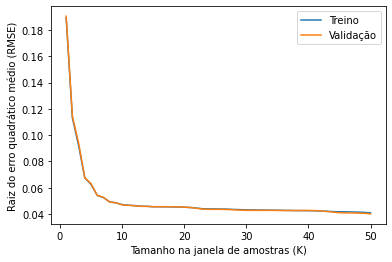

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1,51), train_mse_list)
plt.plot(range(1,51), validation_mse_list)
plt.legend(["Treino", "Validação"])
plt.xlabel("Tamanho na janela de amostras (K)")
plt.ylabel("Raiz do erro quadrático médio (RMSE)")
plt.show()

# Melhor valor de K - 50

In [10]:
min_rmse = min(validation_mse_list)
min_rmse_index = validation_mse_list.index(min_rmse) + 1
print(f"Menor valor de validação: {min_rmse}, K = {min_rmse_index}")

Menor valor de validação: 0.0400962093508727, K = 50


# 1.2 - Previsão a partir do dataset de teste

In [52]:
x_train, y_train = train_loader.get_data(50, 7)
x_validation, y_validation = validation_loader.get_data(50, 7)
x_test, y_test = test_loader.get_data(50, 7)
x_train_full, y_train_full = full_train_loader.get_data(50,7 )

reg_k50 = LinearRegression().fit(x_train_full, y_train_full)


RMSE: 0.04112359634250055


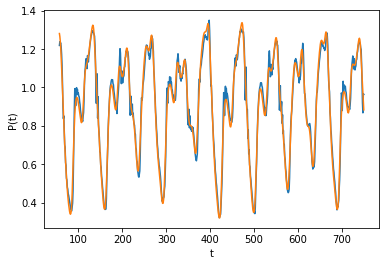

In [53]:
prediction_test = reg_k50.predict(x_test) 
eixo_x = np.array(range(len(x_test))) + 50 + 7


test_rmse = np.sqrt(mean_squared_error(y_test, prediction_test))
print(f"RMSE: {test_rmse}")

plt.plot(eixo_x, prediction_test)
plt.plot(eixo_x, y_test)

plt.xlabel("t")
plt.ylabel("P(t)")
plt.show()

# Exercício 2

## Testando a geração de atributos

In [141]:
V=5
x_train, y_train = train_loader.get_data(10, 7)
random_attributes = np.random.rand(V, 11) * 1
argument = random_attributes.dot(np.asmatrix(x_train[0]).T)
xlinha = np.tanh(argument)
xlinha, argument



(matrix([[0.89427935],
         [0.9399548 ],
         [0.90714602],
         [0.88617576],
         [0.9249731 ]]),
 matrix([[1.44289675],
         [1.73766119],
         [1.51116748],
         [1.40382559],
         [1.62241029]]))

In [90]:
def attribute_transform(samples, V, K, mult_factor=0.1):
    transformed_samples = []
    for sample in samples:
        random_attributes = np.random.rand(V, K + 1) * mult_factor
        wk_xn = random_attributes.dot(np.asmatrix(sample).T)
        transformed_samples.append(wk_xn)
    transformed_samples = np.array(transformed_samples)
    transformed_samples = np.tanh(transformed_samples)
    transformed_samples = transformed_samples.reshape(transformed_samples.shape[0], -1)
    return transformed_samples

x_train_transf = attribute_transform(x_train, 10, 10)
x_train_transf.shape

(3484, 10)

In [144]:
def attribute_transform_v2(samples, V, K,  random_attributes):
    transformed_samples = []
    for sample in samples:
        wk_xn = random_attributes.dot(np.asmatrix(sample).T)
        transformed_samples.append(wk_xn)
    transformed_samples = np.array(transformed_samples)
    transformed_samples = np.tanh(transformed_samples)
    transformed_samples = transformed_samples.reshape(transformed_samples.shape[0], -1)
    return transformed_samples

x_train_transf = attribute_transform(x_train, 10, 10)
x_train_transf.shape

(3484, 10)

In [57]:
def normalize_samples(samples):
    min_val = np.amin(samples)
    max_val = np.amax(samples)
    normalized_samples = (samples - min_val)/(max_val - min_val)
    return normalized_samples
x_norm = normalize_samples(x_train_transf)
np.amin(x_norm), np.amax(x_norm)

(0.0, 1.0)

In [145]:
L = 7
K = 10
mult_factor = 0.1
train_mse_list_transf = []
validation_mse_list_transf = []
for V in range(1,101):
    w_k = np.random.rand(V, K + 1) * mult_factor

    x_train, y_train = train_loader.get_data(K, L)
    x_validation, y_validation = validation_loader.get_data(K, L)
    x_train = attribute_transform_v2(x_train, V, K, random_attributes=w_k)
    x_validation = attribute_transform_v2(x_validation, V, K, random_attributes=w_k)
    #x_train = normalize_samples(x_train)
    #x_validation = normalize_samples(x_validation)
    reg = LinearRegression().fit(x_train, y_train)
    train_prediction = reg.predict(x_train)
    validation_prediction = reg.predict(x_validation)
    validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
    train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
    train_mse_list_transf.append(train_mse)
    validation_mse_list_transf.append(validation_mse)


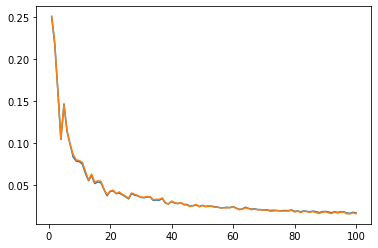

In [146]:
plt.plot(range(1,101), train_mse_list_transf)
plt.plot(range(1,101), validation_mse_list_transf)
plt.show()

In [139]:
x_train, y_train = train_loader.get_data(10, 7)

x_train = attribute_transform(x_train, 10, 10)
x_validation, y_validation = validation_loader.get_data(10, 7)
x_validation = attribute_transform(x_validation, 10, 10)
#x_train = normalize_samples(x_train)
#x_validation = normalize_samples(x_validation)

alpha_list = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
ridge_regression = Ridge(alpha=1e-6, fit_intercept=True)
ridge_regression.fit(x_train, y_train)
validation_prediction = ridge_regression.predict(x_validation)
validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
validation_mse, x_train

(0.24793986418173047,
 array([[0.10529316, 0.09742588, 0.10053625, ..., 0.04897969, 0.04089109,
         0.07170626],
        [0.05424359, 0.09874631, 0.1258746 , ..., 0.09239481, 0.09622417,
         0.10157582],
        [0.09329441, 0.20297904, 0.06956773, ..., 0.08649172, 0.09837804,
         0.06872025],
        ...,
        [0.67558891, 0.69017786, 0.57460212, ..., 0.66765374, 0.55302193,
         0.66298293],
        [0.54126314, 0.47489591, 0.58463283, ..., 0.59975793, 0.53675182,
         0.62837237],
        [0.39614941, 0.45146273, 0.52520461, ..., 0.60205126, 0.64277371,
         0.59222943]]))

In [147]:
from cmath import inf
from random import random


L = 7
K = 10
mult_factor = 0.1
alpha_list = [10000, 1000, 100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0]
best_alpha = [0] * 100
best_train_mse_list = [inf] * 100
best_validation_mse_list =[inf] * 100
for V in range(1,101):
    w_k = np.random.rand(V, K + 1) * mult_factor
    x_train, y_train = train_loader.get_data(K, L)
    x_validation, y_validation = validation_loader.get_data(K, L)
    x_train = attribute_transform_v2(x_train, V, K, random_attributes=w_k)
    x_validation = attribute_transform_v2(x_validation, V, K, random_attributes=w_k)
    for alpha in alpha_list:
        ridge_reg = Ridge(alpha)
        ridge_reg.fit(x_train, y_train)
        train_prediction = ridge_reg.predict(x_train)
        validation_prediction = ridge_reg.predict(x_validation)
        validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
        train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
        if validation_mse < best_validation_mse_list[V - 1]:
            best_validation_mse_list[V - 1] = validation_mse
            best_train_mse_list[V-1] = train_mse
            best_alpha[V-1] = alpha



/Users/pdcos/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.84738e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/pdcos/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.12989e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/pdcos/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.55117e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/pdcos/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.01695e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/pdcos/Library/Python/

In [148]:
max(best_alpha)

1

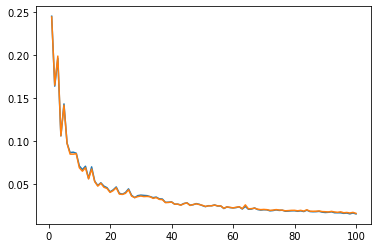

In [149]:
plt.plot(range(1,101), best_validation_mse_list)
plt.plot(range(1,101), best_train_mse_list)
plt.show()

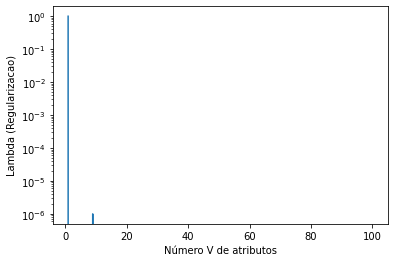

In [150]:
plt.plot(range(1,101), best_alpha)
plt.yscale("log")
plt.xlabel("Número V de atributos")
plt.ylabel("Lambda (Regularizacao)")
plt.show()

In [152]:
min_rmse = min(best_validation_mse_list)
min_rmse_index = best_validation_mse_list.index(min_rmse) + 1
print(f"Menor valor de validação: {min_rmse}, V = {min_rmse_index}, Lambda = {best_alpha[ min_rmse_index - 1]}")

Menor valor de validação: 0.015252901688265414, V = 100, Lambda = 0


RMSE: 0.015477297002066051


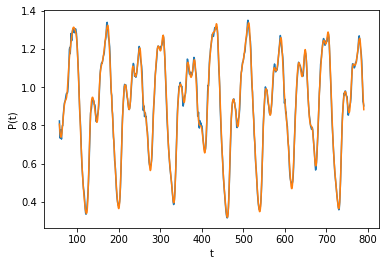

In [156]:
K=10
L=7
V=100
mult_factor = 0.1
w_k = np.random.rand(V, K + 1) * mult_factor

x_train_full, y_train_full = full_train_loader.get_data(K, L)
x_test, y_test = test_loader.get_data(K,L)
x_train_full = attribute_transform_v2(x_train_full, V, K, random_attributes=w_k)
x_test = attribute_transform_v2(x_test, V, K, random_attributes=w_k)
#x_train_full = normalize_samples(x_train_full)
#x_test = normalize_samples(x_test)
#x_test = x_test**4
#print(x_test )

best_ridge = Ridge(alpha=best_alpha[ min_rmse_index - 1])
best_ridge.fit(x_train_full, y_train_full)

prediction_test = best_ridge.predict(x_test) 
#prediction_test = prediction_test ** 4
eixo_x = np.array(range(len(x_test))) + 50 + 7

#prediction_test = (prediction_test - 0.35)/(1.3- 0.35)

test_rmse = np.sqrt(mean_squared_error(y_test, prediction_test))
print(f"RMSE: {test_rmse}")

plt.plot(eixo_x, prediction_test)
plt.plot(eixo_x, y_test)
plt.xlabel("t")
plt.ylabel("P(t)")
plt.show()